In [1]:
import h5py


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D,Conv2DTranspose


In [3]:
img_height, img_width = 128,128

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):

  img = tf.image.decode_bmp(img)
  img = img[..., :3]
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):

  img = tf.image.decode_jpeg(img, channels=1)
  img = img[..., :3]
  img = tf.image.grayscale_to_rgb(img)
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = normalize(decode_img(tf.io.read_file(file_path)))
    img = tf.image.resize(img, [128, 128])
    
    file_id = tf.strings.split(file_path, '/')[-1]  # Get the file name from the path
    file_id = tf.strings.regex_replace(file_id, '\\.bmp$', '')  # Remove .bmp extension

    # Dynamically construct paths using tf.strings.join
    table_mask_path = tf.strings.join(['Mdata/table_mask/', file_id, '.jpeg'])
    column_mask_path = tf.strings.join(['Mdata/column_mask/', file_id, '.jpeg'])

    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_path)))
    column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_path)))

    return img, {"table_output": table_mask, "column_output": column_mask}


In [5]:
import os
directory = 'Marmot_data'
files_and_dirs = os.listdir(directory)
num_files = len(files_and_dirs)

print(f"Number of files and directories in the folder: {num_files}")

Number of files and directories in the folder: 990


In [21]:

bmp_files = tf.io.gfile.glob('Marmot_data/*.bmp')


# Filter out file paths that no longer exist and normalize them
valid_files = [os.path.normpath(f).replace('\\', '/') for f in bmp_files if tf.io.gfile.exists(f)]
#print(valid_files)


bmp_files_tensor = tf.convert_to_tensor(valid_files, dtype=tf.string)

# Create the updated tf.data.Dataset with normalized files only
list_ds = tf.data.Dataset.from_tensor_slices(bmp_files_tensor)
#print(type(list_ds))
print(len(list_ds))

494


In [12]:
def augment_images_and_masks(image, table_mask, column_mask):
    # Zoom
    scale = tf.random.uniform([], 0.8, 1.2)  # Random zoom factor
    image = tf.image.resize(image, [int(128 * scale), int(128 * scale)])
    table_mask = tf.image.resize(table_mask, [int(128 * scale), int(128 * scale)])
    column_mask = tf.image.resize(column_mask, [int(128 * scale), int(128 * scale)])
    
    # Randomly crop back to original size
    image = tf.image.resize_with_crop_or_pad(image, 128, 128)
    table_mask = tf.image.resize_with_crop_or_pad(table_mask, 128, 128)
    column_mask = tf.image.resize_with_crop_or_pad(column_mask, 128, 128)

    # Contrast Adjustment (applied to image only)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, table_mask, column_mask


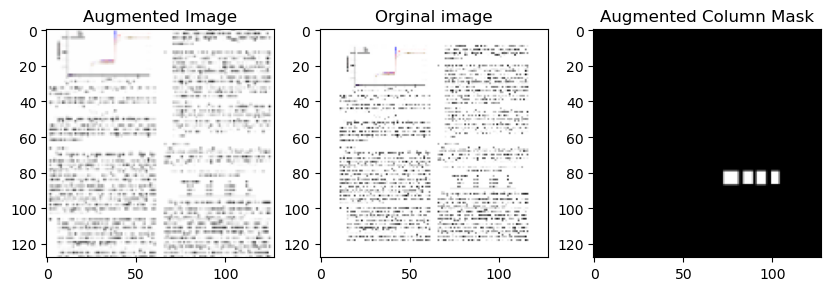

In [9]:
# Choose a sample image and mask from your dataset
sample_image_path = 'Marmot_data/10.1.1.1.2006_3.bmp'
sample_image, sample_masks = process_path(sample_image_path)

# Apply augmentation
augmented_image, augmented_table_mask = augment_images_and_masks(sample_image, sample_masks["table_output"])
augmented_column_mask = augment_images_and_masks(sample_image, sample_masks["column_output"])[1]  # Only extract the mask part

# Visualize the augmented result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Augmented Image")
plt.imshow(augmented_image)

plt.subplot(1, 3, 2)
plt.title("Orginal image")
plt.imshow(sample_image)

plt.subplot(1, 3, 3)
plt.title("Augmented Column Mask")
plt.imshow(augmented_column_mask)
plt.show()


In [23]:

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)
TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)
train_dataset = train.shuffle(50).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test.shuffle(50).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
print(TRAIN_LENGTH)

444


In [17]:
len(train_dataset)

222

In [19]:
len(test_dataset)

25

In [24]:
augmentation_count = 150
BATCH_SIZE = 2  # Keeping your original batch size

def generate_augmented_samples(dataset, augmentation_count):
    augmented_images = []
    augmented_table_masks = []
    augmented_column_masks = []
    
    for _ in range(augmentation_count):
        # Randomly sample an image from the dataset
        img, masks = next(iter(dataset))
        
        # Apply augmentation
        aug_img, aug_table_mask, aug_column_mask = augment_images_and_masks(img, masks["table_output"], masks["column_output"])
        
        # Append the augmented image and masks to the lists
        augmented_images.append(aug_img)
        augmented_table_masks.append(aug_table_mask)
        augmented_column_masks.append(aug_column_mask)
    
    # Convert lists to tensors and create a new dataset for augmented images and masks
    augmented_ds = tf.data.Dataset.from_tensor_slices(
        (augmented_images, {"table_output": augmented_table_masks, "column_output": augmented_column_masks})
    )
    
    # Batch the augmented dataset
    augmented_ds = augmented_ds.batch(BATCH_SIZE)
    
    return augmented_ds

# Generate the augmented dataset
augmented_dataset = generate_augmented_samples(train, augmentation_count)

# Concatenate the augmented dataset with the original train_dataset
train_dataset = train_dataset.concatenate(augmented_dataset)

# Check the length of the train_dataset
print(f"Total batches in train_dataset after augmentation: {len(train_dataset)}")


Total batches in train_dataset after augmentation: 297


In [25]:
len(train_dataset)

297

In [26]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128, 3))

# Print all layer names and output shapes
for layer in base_model.layers:
    print(layer.name, layer.output_shape)

input_1 [(None, 128, 128, 3)]
conv2d (None, 63, 63, 32)
batch_normalization (None, 63, 63, 32)
activation (None, 63, 63, 32)
conv2d_1 (None, 61, 61, 32)
batch_normalization_1 (None, 61, 61, 32)
activation_1 (None, 61, 61, 32)
conv2d_2 (None, 61, 61, 64)
batch_normalization_2 (None, 61, 61, 64)
activation_2 (None, 61, 61, 64)
max_pooling2d (None, 30, 30, 64)
conv2d_3 (None, 30, 30, 80)
batch_normalization_3 (None, 30, 30, 80)
activation_3 (None, 30, 30, 80)
conv2d_4 (None, 28, 28, 192)
batch_normalization_4 (None, 28, 28, 192)
activation_4 (None, 28, 28, 192)
max_pooling2d_1 (None, 13, 13, 192)
conv2d_8 (None, 13, 13, 64)
batch_normalization_8 (None, 13, 13, 64)
activation_8 (None, 13, 13, 64)
conv2d_6 (None, 13, 13, 48)
conv2d_9 (None, 13, 13, 96)
batch_normalization_6 (None, 13, 13, 48)
batch_normalization_9 (None, 13, 13, 96)
activation_6 (None, 13, 13, 48)
activation_9 (None, 13, 13, 96)
average_pooling2d (None, 13, 13, 192)
conv2d_5 (None, 13, 13, 64)
conv2d_7 (None, 13, 13, 64)
co

In [27]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Cropping2D, Dropout, concatenate,ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

class GNet:
    def base_model(input_shape=(128, 128, 3)):
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
        skip_layers = ['mixed0', 'mixed3', 'mixed5']
        encoder_outputs = [base_model.get_layer(name).output for name in skip_layers]
        return base_model, encoder_outputs
    def table_decoder(x, encoder_outputs):
        x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
       
        x = Dropout(0.4)(x)
        x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.01))(x)
        x = ReLU()(x)  # Add ReLU activation
        x = Cropping2D(cropping=((1, 1), (1, 1)))(x)
        
        skip_connection = Conv2D(512, (1, 1), padding='same', kernel_regularizer=l2(0.01))(encoder_outputs[2])
        skip_connection = ReLU()(skip_connection)  # Add ReLU after skip connection
        x = concatenate([x, skip_connection])
        x = Dropout(0.4)(x)  # Dropout after skip connection
        return x
    
    def column_decoder(x, encoder_outputs):
        x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.01))(x)
  
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
        
        skip_connection = Conv2D(512, (1, 1), padding='same', kernel_regularizer=l2(0.01))(encoder_outputs[1])
        skip_connection = ReLU()(skip_connection)  # Add ReLU after skip connection
        x = concatenate([x, skip_connection])
        x = Dropout(0.7)(x)
        return x

    def build(input_shape=(128, 128, 3)):
        base_model, encoder_outputs = GNet.base_model(input_shape)
        for layer in base_model.layers:
            layer.trainable = False

        x = base_model.get_layer('mixed10').output
        x = GNet.table_decoder(x, encoder_outputs)
        x = GNet.column_decoder(x, encoder_outputs)
        x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.01))(x)
        #x = Dropout(0.4)(x)
        x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
        x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
        #x = Dropout(0.4)(x)
        x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
        #x = Dropout(0.4)(x)
        x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.01))(x)
        x = Cropping2D(cropping=((32, 32), (32, 32)))(x)
        x = Conv2D(3, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
        table_mask = Conv2D(3, (1, 1), activation='sigmoid', name='table_output')(x)
        column_mask = Conv2D(3, (1, 1), activation='sigmoid', name='column_output')(x)

        model = Model(inputs=base_model.input, outputs=[table_mask, column_mask])

        return model

model = GNet.build(input_shape=(128, 128, 3))
model.summary() 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 0.0001
    decay_rate = 0.96
    decay_steps = 10
    return initial_lr * decay_rate ** (epoch / decay_steps)
optimizer=Adam(learning_rate=0.001,beta_1=0.9, 
    beta_2=0.999)
lr_callback = LearningRateScheduler(lr_schedule)
loss_weights = {'table_output': 1.0, 'column_output': 1.0}

model.compile(optimizer=optimizer, 
              loss={'table_output': 'binary_crossentropy', 'column_output': 'binary_crossentropy'},
              loss_weights=loss_weights,
               metrics={'table_output': 'accuracy', 'column_output': 'accuracy'}
             )

(128, 128, 3)


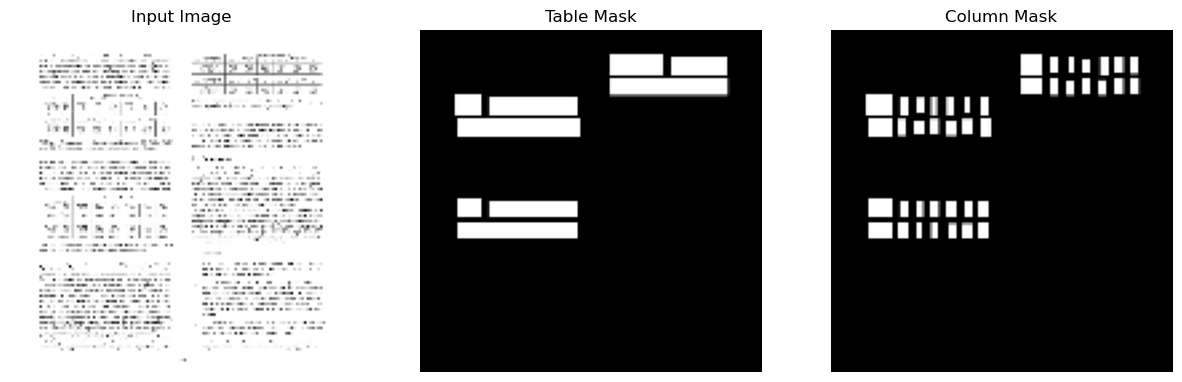

In [29]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


for image,mask in train.take(1):

  print(image.shape)
  #print(mask.shape)
  display([image, mask['table_output'], mask['column_output']])

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath="stored_model/6/mymodel_{epoch}.keras",
            save_best_only=True,
            monitor="val_loss",
            verbose=1,
        )
    
    early_stoping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
        )

In [31]:
tf.debugging.set_log_device_placement(True)
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(),lr_callback])
model.save('stored_model/6/model_googlenet_new6.keras')

Epoch 1/50
222/222 [==============================] - 31s 88ms/step - loss: 14.8945 - table_output_loss: 0.6773 - column_output_loss: 0.6888 - table_output_accuracy: 0.0211 - column_output_accuracy: 0.0166 - val_loss: 6.4771 - val_table_output_loss: 0.6765 - val_column_output_loss: 0.6892 - val_table_output_accuracy: 0.0000e+00 - val_column_output_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
222/222 [==============================] - 6s 27ms/step - loss: 5.5061 - table_output_loss: 0.6687 - column_output_loss: 0.6819 - table_output_accuracy: 2.1566e-05 - column_output_accuracy: 2.0752e-05 - val_loss: 4.6796 - val_table_output_loss: 0.6639 - val_column_output_loss: 0.6797 - val_table_output_accuracy: 0.0000e+00 - val_column_output_accuracy: 0.0000e+00 - lr: 9.9593e-05


In [32]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  pred_mask1 = tf.image.resize(pred_mask1, (256, 256))
  pred_mask1 = tf.image.grayscale_to_rgb(pred_mask1)
  pred_mask2 = tf.image.resize(pred_mask2, (256, 256))
  pred_mask2 = tf.image.grayscale_to_rgb(pred_mask2)
  pred_mask2=tf.squeeze(pred_mask2)
  pred_mask1=tf.squeeze(pred_mask1)
  return pred_mask1, pred_mask2

In [33]:
for image, mask in train.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
sample_image_batch = tf.expand_dims(sample_image, axis=0)
pred_mask1, pred_mask2 = model.predict(sample_image_batch, verbose=1)
print(type(pred_mask1))
print(pred_mask1.shape)

1/1 [==============================] - 4s 4s/step
<class 'numpy.ndarray'>
(1, 128, 128, 3)


In [36]:
def create_mask_column(pred_mask):
    segmented_mask = tf.argmax(pred_mask, axis=-1)

    #mask = tf.round(predictions) 
    segmented_mask = segmented_mask[..., tf.newaxis]
    return segmented_mask
def create_mask_table(pred_mask):
    segmented_mask=tf.round(pred_mask)
    return segmented_mask

1/1 [==============================] - 0s 35ms/step
Unique values in table predictions: tf.Tensor([0.3631902  0.42504913 0.6013075  ... 0.4229344  0.456764   0.5509231 ], shape=(3204,), dtype=float32)
Unique values in column predictions: tf.Tensor([0.377806   0.6177745  0.446806   ... 0.4309589  0.55994636 0.46834654], shape=(3204,), dtype=float32)


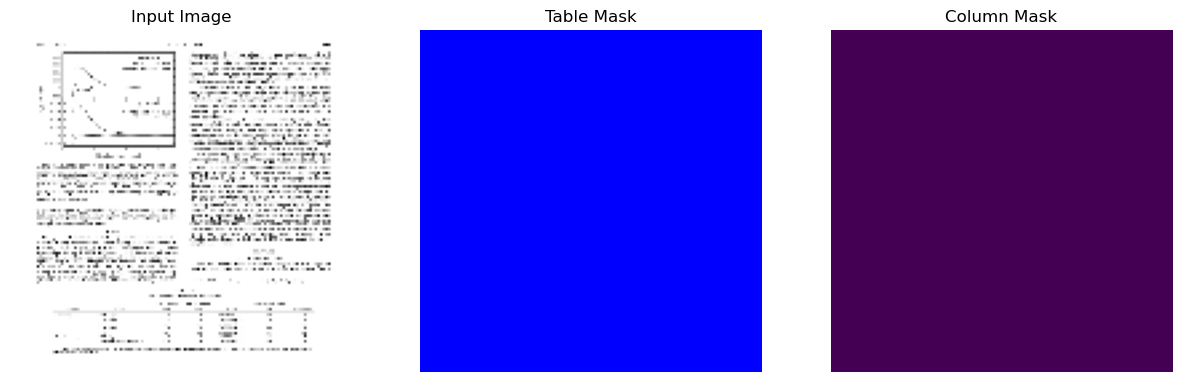

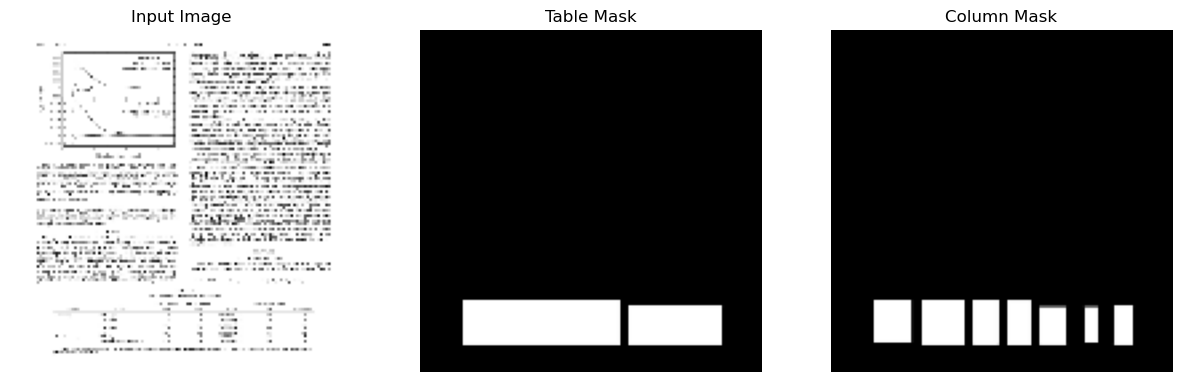

In [37]:
for image, mask in test.take(1):
    predictions = model.predict(image[tf.newaxis, ...])

    # Flatten the prediction tensors to 1D vectors for unique value check
    table_prediction_flat = tf.reshape(predictions[0], [-1])
    column_prediction_flat = tf.reshape(predictions[1], [-1])

    # Check unique values in predictions
    print("Unique values in table predictions:", tf.unique(table_prediction_flat)[0])
    print("Unique values in column predictions:", tf.unique(column_prediction_flat)[0])

    # Apply mask creation
    table_mask = tf.squeeze(create_mask_table(predictions[0]),axis=0)
    column_mask = tf.squeeze(create_mask_column(predictions[1]), axis=0)

    # Visualize the results
    display([image, table_mask, column_mask])
    display([image, mask['table_output'], mask['column_output']])

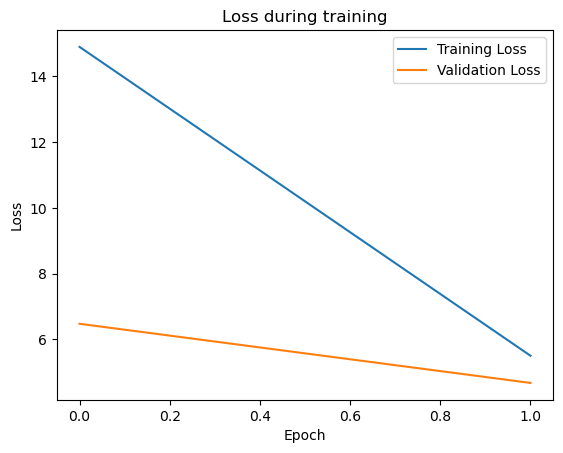

In [38]:
import matplotlib.pyplot as plt

# Assuming `history` is the object returned by model.fit()
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Lists to store predictions and true labels for both table and column masks
y_true_table, y_pred_table = [], []
y_true_column, y_pred_column = [], []

# Define a threshold to binarize predictions
threshold_value = 0.5

# Step 1: Iterate over batches in the test dataset
for image_batch, label_batch in test_dataset:
    # Step 2: Predict the masks for the current batch
    predictions = model.predict(image_batch)
    
    # Step 3: Extract predicted masks
    predicted_table_mask = predictions[0]
    predicted_column_mask = predictions[1]
    
    # Convert predictions to binary masks (for pixel-wise classification)
    binary_table_pred = np.where(predicted_table_mask > threshold_value, 1, 0).astype(np.uint8)
    binary_column_pred = np.where(predicted_column_mask > threshold_value, 1, 0).astype(np.uint8)
    
    # Step 4: Append predictions and true labels for table mask
    y_pred_table.extend(binary_table_pred.flatten())
    y_true_table.extend(label_batch["table_output"].numpy().astype(np.uint8).flatten())
    
    # Step 5: Append predictions and true labels for column mask
    y_pred_column.extend(binary_column_pred.flatten())
    y_true_column.extend(label_batch["column_output"].numpy().astype(np.uint8).flatten())

# Step 6: Calculate F1 score, precision, recall, and accuracy for table_output
f1_table = f1_score(y_true_table, y_pred_table, average='weighted')
precision_table = precision_score(y_true_table, y_pred_table, average='weighted')
recall_table = recall_score(y_true_table, y_pred_table, average='weighted')
accuracy_table = accuracy_score(y_true_table, y_pred_table)

# Step 7: Calculate F1 score, precision, recall, and accuracy for column_output
f1_column = f1_score(y_true_column, y_pred_column, average='weighted')
precision_column = precision_score(y_true_column, y_pred_column, average='weighted')
recall_column = recall_score(y_true_column, y_pred_column, average='weighted')
accuracy_column = accuracy_score(y_true_column, y_pred_column)

# Output the metrics
print(f"Table Output - F1 Score: {f1_table}, Precision: {precision_table}, Recall: {recall_table}, Accuracy: {accuracy_table}")
print(f"Column Output - F1 Score: {f1_column}, Precision: {precision_column}, Recall: {recall_column}, Accuracy: {accuracy_column}")


1/1 [==============================] - 0s 30ms/step
Table Output - F1 Score: 0.6618739185337578, Precision: 0.7366756953269242, Recall: 0.6146675618489583, Accuracy: 0.6146675618489583
Column Output - F1 Score: 0.6888920937407697, Precision: 0.7890523988723754, Recall: 0.6267220052083333, Accuracy: 0.6267220052083333
